In [1]:
import mediapipe as mp
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Data Loading

In [2]:
def get_centroid_details(file_path, visualize=False):
    """This function gets centroid coordinates using mediapipe from a video file

    Args:
        file_path (string): This is the path of the video file
        visualize (bool, optional): Provides a visualization for the pose tracking. Defaults to False.

    Returns:
        dict: This dictionary contains a list of upper body pose estimates
    """
    cap = cv2.VideoCapture(file_path)
    mp_pose = mp.solutions.pose

    rh_centroid_x = []
    rh_centroid_y = []

    lh_centroid_x = []
    lh_centroid_y = []

    with mp_pose.Pose(
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    ) as pose:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_height, image_width, _ = image.shape

            centroid_results = pose.process(image)

            rh_centroid_x_frame = []
            rh_centroid_y_frame = []

            lh_centroid_x_frame = []
            lh_centroid_y_frame = []

            right_hand_coords=[16, 18, 20, 22]
            left_hand_coords=[15, 17, 21, 19]

            for i in (right_hand_coords):
                rh_centroid_x_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].x * image_width, 2)
                )
                rh_centroid_y_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].y * image_height, 2)
                )

            for i in (left_hand_coords):
                lh_centroid_x_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].x * image_width, 2)
                )
                lh_centroid_y_frame.append(
                    round(centroid_results.pose_landmarks.landmark[i].y * image_height, 2)
                )
            # calculate centroid by taking the arithmetic mean of coordinates
            rh_centroid_x.append(round(sum(rh_centroid_x_frame)/len(rh_centroid_x_frame), 2))
            rh_centroid_y.append(round(sum(lh_centroid_y_frame)/len(lh_centroid_y_frame), 2))

            lh_centroid_x.append(round(sum(lh_centroid_x_frame)/len(lh_centroid_x_frame), 2))
            lh_centroid_y.append(round(sum(lh_centroid_y_frame)/len(lh_centroid_y_frame), 2))

            # visualizing the pose analysis
            if visualize:
                mp_drawing = mp.solutions.drawing_utils
                mp_drawing_styles = mp.solutions.drawing_styles
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                mp_drawing.draw_landmarks(
                    image,
                    centroid_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
                )
                cv2.imshow("MediaPipe Pose", cv2.flip(image, 1))
                if cv2.waitKey(5) & 0xFF == 27:
                    break
    cap.release()


In [64]:
data_path="../../data/sample_videos/sample1.mp4"
_, vid_file_name = os.path.split(data_path)
video = cv2.VideoCapture(data_path)

## Video Processing

In [65]:
# centroid = get_centroid_details(data_path)
initial_no_frames=len(centroid["right_hand_x"])

In [ ]:
# writing centroid
with open("../output/result.json", "w") as f:
    f.write(json.dumps(centroid))

In [73]:
# reading centroid

with open("../output/result.json", "r") as json_file:
    centroid = json.load(json_file)

Finding out the hand distance parameter for all the frames

In [74]:
right_x = centroid["right_hand_x"]
right_y = centroid["right_hand_y"]
left_x = centroid["left_hand_x"]
left_y = centroid["left_hand_y"]

hand_distance=[]

def euc_dist(x1, x2, y1, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

for i in range(1, initial_no_frames):
    right_distance = euc_dist(right_x[i], right_x[i-1], right_y[i], right_y[i-1])
    left_distance = euc_dist(left_x[i], left_x[i-1], left_y[i], left_y[i-1])
    hand_distance.append(max(right_distance, left_distance))


Finding out the hand height parameter for all the frames

In [75]:
hand_height=[]
for i in range(initial_no_frames):
    hand_height.append(min(right_y[i], left_y[i]))


Plotting the hand distance for each frame in the video file to see how the value changes. Also plotting a threshold that takes points that show less than 10% of the maximum hand distance

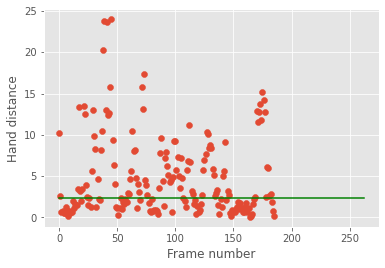

In [76]:
plt.scatter([i for i in range(0, initial_no_frames-1)], hand_distance)
alpha=0.1*max(hand_distance)
plt.plot([0, 262], [alpha, alpha], color="green")

plt.ylabel("Hand distance")
plt.xlabel("Frame number")
plt.show()


Plotting the hand height for each frame in the video file to see how the value changes. Also plotting a line through the average of hand height values to represent a threshold to select the frames

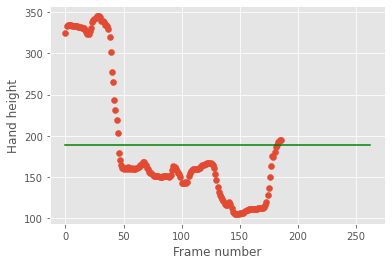

In [77]:
plt.scatter([i for i in range(0, initial_no_frames)], hand_height)
beta=round(sum(hand_height)/len(hand_height),2)
plt.plot([0, 262], [beta, beta], color="green")


plt.ylabel("Hand height")
plt.xlabel("Frame number")
plt.show()

Using the computed thresholds to output the processed video file

In [78]:
video = cv2.VideoCapture(data_path)
output_path = os.path.join("../output/", vid_file_name.split(".")[0] + ".mp4")
fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
dim=(int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(video.get(cv2.CAP_PROP_FRAME_WIDTH)))
output = cv2.VideoWriter(output_path, fourcc, video.get(cv2.CAP_PROP_FPS), dim)

frame_num=0
output_frames=0
while True:
    ret, frame = video.read()
    if not ret:
        break
    if(hand_distance[frame_num-1]>alpha and frame_num!=0):
        output.write(frame)
        output_frames+=1
    elif(hand_height[frame_num]<beta):
        output.write(frame)
        output_frames+=1
    frame_num+=1
output.release()


IndexError: list index out of range

Creating video summary dictionary to store the video metadata

In [63]:
video_summary={}
video_summary["Filename"]=vid_file_name
video_summary["Hand_Height"]=hand_height
video_summary["Hand_Distance"]=hand_distance
video_summary["Initial_Frame_Count"]=initial_no_frames
video_summary["Post_KFS_Frame_Count"]=output_frames
video_summary["Percentage_Reduction"]=round(((initial_no_frames-output_frames)/initial_no_frames)*100, 2)
video_summary["Hand_Height_Threshold_Value"]=beta
video_summary["Hand_Distance_Threshold_Value"]=alpha

output_path = os.path.join("../output/", vid_file_name.split(".")[0] + ".json")

with open(output_path, "w") as f:
    f.write(json.dumps(video_summary))